In [0]:
%reload_ext autoreload 
%autoreload 2 
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
bs = 64

In [0]:
img = open_image('ISIC_0000000.jpg')

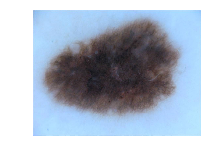

In [0]:
img.show()

In [0]:
img.data.shape

torch.Size([3, 767, 1022])

Using cmap so single channel

torch.Size([1, 767, 1022])


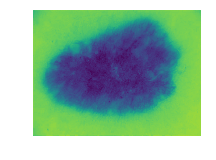

In [0]:
img = open_image('ISIC_0000000.jpg', convert_mode='L'); print(img.shape)
img.show()

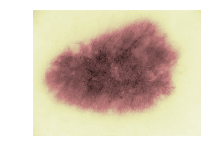

In [0]:
img.show(cmap='pink')

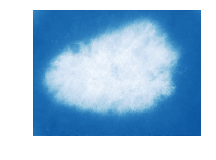

In [0]:
defaults.cmap = 'Blues'
img.show()

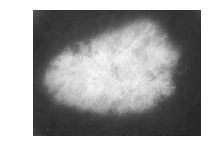

In [0]:
defaults.cmap = 'binary'
img.show()

In [0]:
def get_ex(): return open_image('ISIC_0000000.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

In [0]:
tfms = get_transforms()
type(tfms)

tuple

In [0]:
len(tfms)

2

**one for training and one for validation. Validation requires little to no resizing**

Fastai does a few transforms by default. we ared oing resizing here

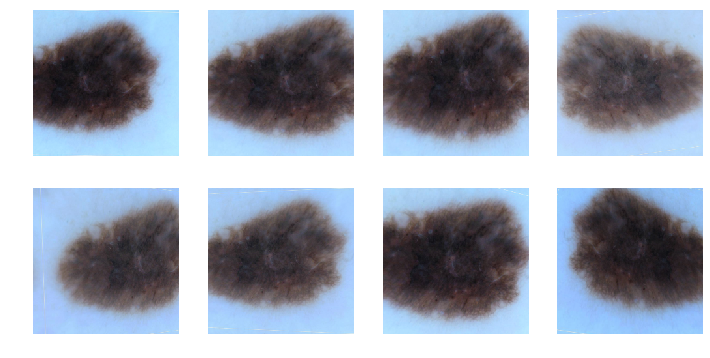

In [0]:
plots_f(2, 4, 12, 6, size=224)

rotation between +180 to -180

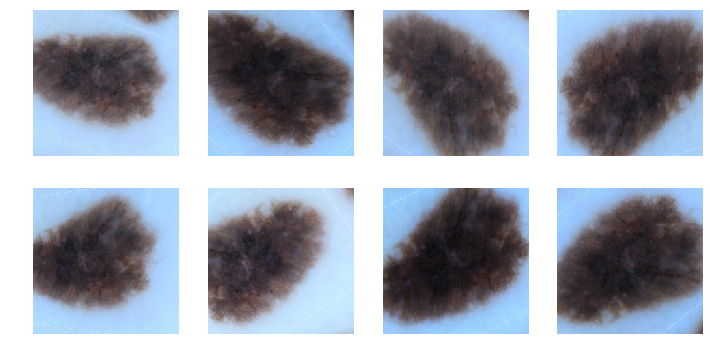

In [0]:
tfms = get_transforms(max_rotate=180)
plots_f(2, 4, 12, 6, size=224)

brightness transform. A bit typical to apply. Comes under xtra_tfms


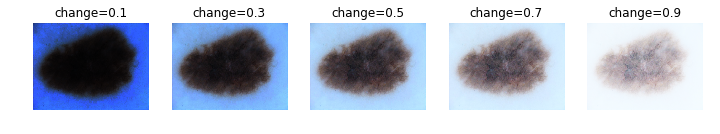

In [0]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for change, ax in zip(np.linspace(0.1,0.9,5), axs):
    brightness(get_ex(), change).show(ax=ax, title=f'change={change:.1f}')

Contrast twiddling

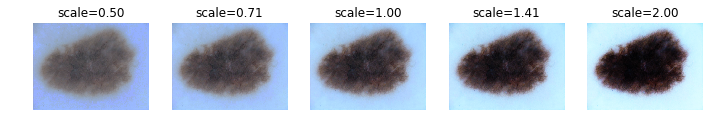

In [0]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for scale, ax in zip(np.exp(np.linspace(log(0.5),log(2),5)), axs):
    contrast(get_ex(), scale).show(ax=ax, title=f'scale={scale:.2f}')

Cropping

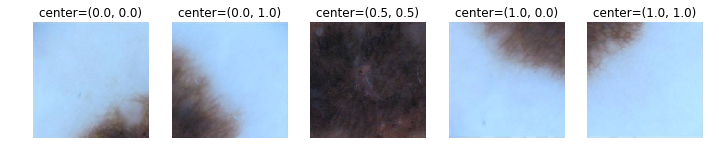

In [0]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for center, ax in zip([[0.,0.], [0.,1.],[0.5,0.5],[1.,0.], [1.,1.]], axs):
    crop(get_ex(), 300, *center).show(ax=ax, title=f'center=({center[0]}, {center[1]})')

Cropping with zero and reflection padding

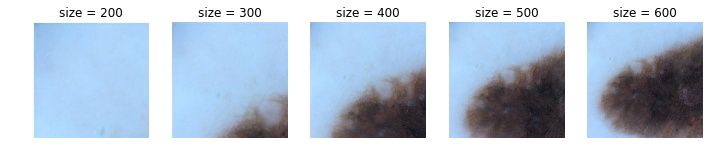

In [0]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for size, ax in zip(np.linspace(200,600,5), axs):
    crop_pad(get_ex(), int(size), 'zeros', 0.,0.).show(ax=ax, title=f'size = {int(size)}')
#zero padding makes black spaces when area is cropped out

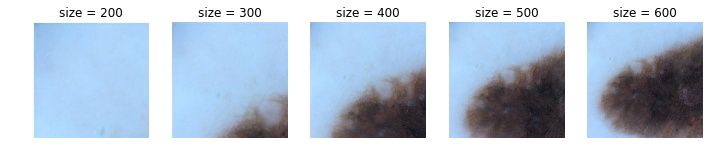

In [0]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for size, ax in zip(np.linspace(200,600,5), axs):
    crop_pad(get_ex(), int(size), 'reflection', 0.,0.).show(ax=ax, title=f'size = {int(size)}')
#reflection padding makes the object reflect if the box contains black areas

rotation in 8 possible directions

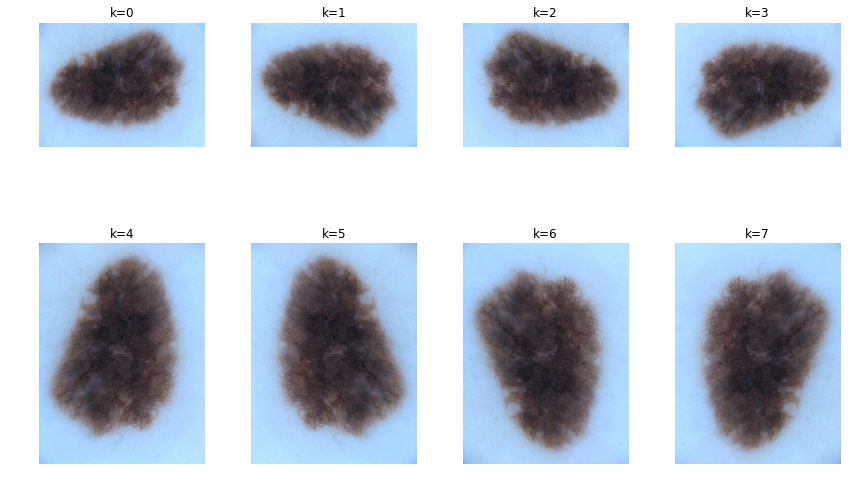

In [0]:
fig, axs = plt.subplots(2,4,figsize=(12,8))
for k, ax in enumerate(axs.flatten()):
    dihedral(get_ex(), k).show(ax=ax, title=f'k={k}')
plt.tight_layout()

introducing noise

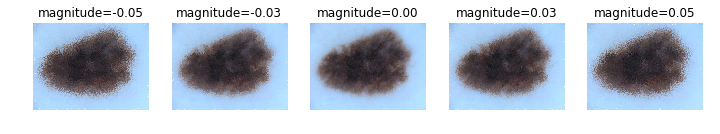

In [0]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for magnitude, ax in zip(np.linspace(-0.05,0.05,5), axs):
    tfm = jitter(magnitude=magnitude)
    get_ex().jitter(magnitude).show(ax=ax, title=f'magnitude={magnitude:.2f}')

skewing viewing angle

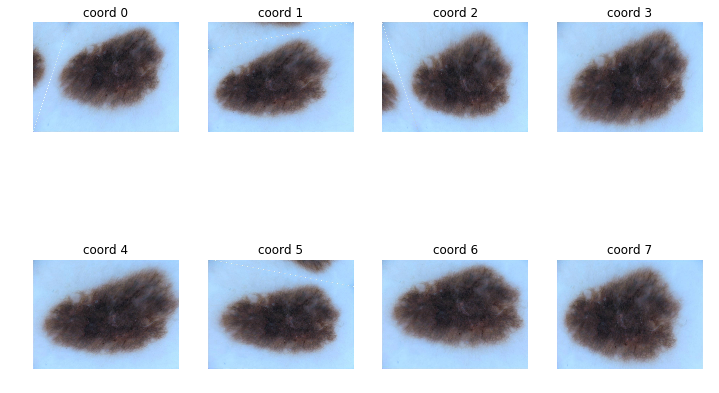

In [0]:
fig, axs = plt.subplots(2,4,figsize=(12,8))
for i, ax in enumerate(axs.flatten()):
    magnitudes = torch.tensor(np.zeros(8))
    magnitudes[i] = 0.5
    perspective_warp(get_ex(), magnitudes).show(ax=ax, title=f'coord {i}')

Symmetric warping

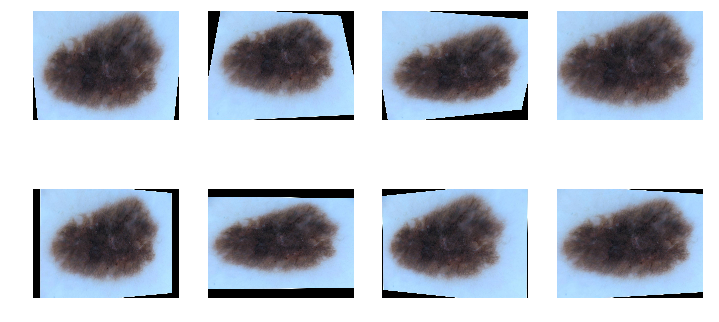

In [0]:
tfm = symmetric_warp(magnitude=(-0.2,0.2))
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = get_ex().apply_tfms(tfm, padding_mode='zeros')
    img.show(ax=ax)

tilting

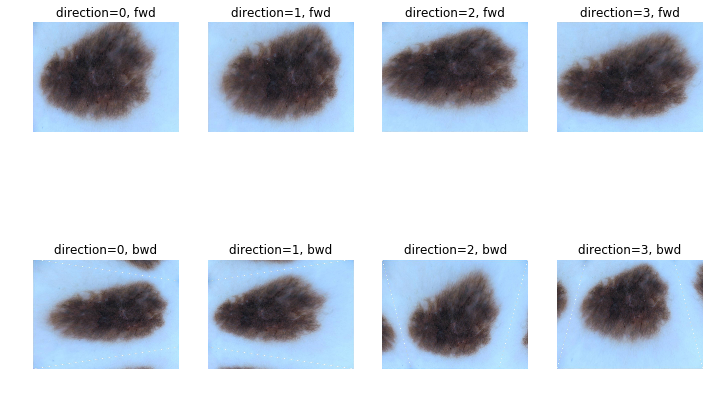

In [0]:
fig, axs = plt.subplots(2,4,figsize=(12,8))
for i in range(4):
    get_ex().tilt(i, 0.4).show(ax=axs[0,i], title=f'direction={i}, fwd')
    get_ex().tilt(i, -0.4).show(ax=axs[1,i], title=f'direction={i}, bwd')

In [0]:
import PIL
import numpy as np
import torch
import torchvision

In [5]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-tj2mrrhi
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-tj2mrrhi
     |████████████████████████████████| 20.0MB 2.7MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-elnm15g9/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug


Some advanced transforms using imgaug

In [24]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),#scale
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),#gaussian blur
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms = ImgAugTransform()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  after removing the cwd from sys.path.


In [0]:
!cd data && mkdir typ1


In [0]:
dataset = torchvision.datasets.ImageFolder('data', transform=transforms)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


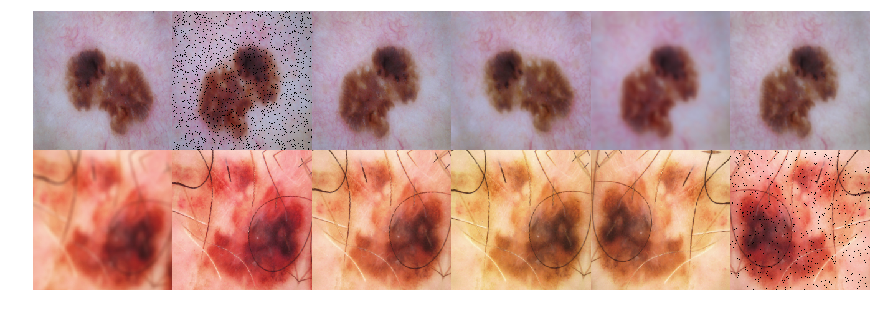

In [23]:
show_dataset(dataset)